# Stereo Matching - Exercise 2024
**Goal:** The goal of the practical part of this course is the implementation of a local stereo matching algorithm based on the paper Hosni et al. “REAL-TIME LOCAL STEREO MATCHING USING GUIDED IMAGE FILTERING”. The paper can be downloaded from the TUWEL course.  The exercise is split into multiple parts; during the first task, you will implement a simple block-based stereo algorithm. In the second part, you will refine the previous results using guided filtering. After that, you will have to implement a post-processing procedure to enhance the quality of your final disparity map. For the final part of this exercise, we will calculate evaluation metrics to quantitatively assess the result.

**Formalities:** This exercise is part of the VU Stereo Vision (188.513). The LV consists of the lecture, and the corresponding written exam on the 26. June 2024 at 15:00, and this exercise which is due on the 12. June 2024 at 23:59. Each of those is mandatory and needs to be passed, where the final grade is made up of 50% from the exam and 50% of this exercise. Each of the four tasks within this exercise is mandatory and you must get at least 50% in each of them to get a passing grade. The exercise should be conducted in groups of two. Insert your code at the `#TODO` tags. You may use any functions available in Numpy and OpenCV to solve the tasks. The exercise description is in the corresponding exercise sheet, so please read this carefully.

**Submission:** The deadline for this exercise is the 12. June 2024 at 23:59 and the file must be uploaded via the TUWEL course. The submission must be a zip file containing your Jupyter Notebook and the notebook exported as an html file.

**Contact:** If you have any questions about the exercise, please post them in the exercise forum in TUWEL and we will answer them in a timely manner. 

**Your names and student ID:** Maximilian Scheiber 12144091

## Imports and configuration

In [35]:
## Imports and configuration
import numpy as np
import cv2 as cv
import jupyter_compare_view
import guided_filter

from tqdm.notebook import trange, tqdm
from matplotlib import pyplot as plt
from joblib import Parallel, delayed

plt.rcParams['figure.figsize'] = [10, 5] # controls plot size in inch

## Task 1 - Cost Volume Calculation (25 points)
- Read and display input images. (5 points)
- Compute cost volume with color cost and gradient cost terms. (10 points)
- Apply average filter and select best disparity values from cost volume. (5 points)
- Find suitable parameters and visualize disparity. (5 points)  


#### Read and display input images


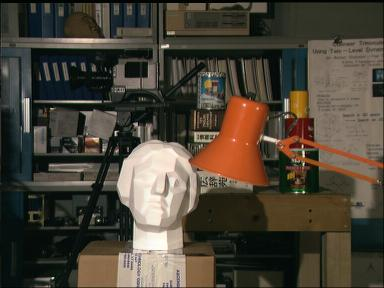
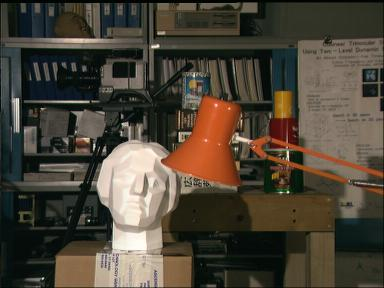

In [36]:
# image paths
left_image_path = 'scene1.row3.col3.ppm' # load tsukuba images
right_image_path = 'scene1.row3.col5.ppm'
gt_path = 'truedisp.row3.col3.pgm'
gt_scale = 0 # HINT: find information about how to scale the ground truth disparity on the middleburry website

def read_image(image_path):
    # TODO: read input images
    img = cv.imread(image_path, cv.IMREAD_UNCHANGED)
    img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    return img

left_image = read_image(left_image_path)
right_image = read_image(right_image_path)
gt = read_image(gt_path)

def plot_compare(image, disparity, height):
    return jupyter_compare_view.compare(image, disparity, height=height)

plot_compare(left_image, right_image, 400)

#### Implement cost volume calculation

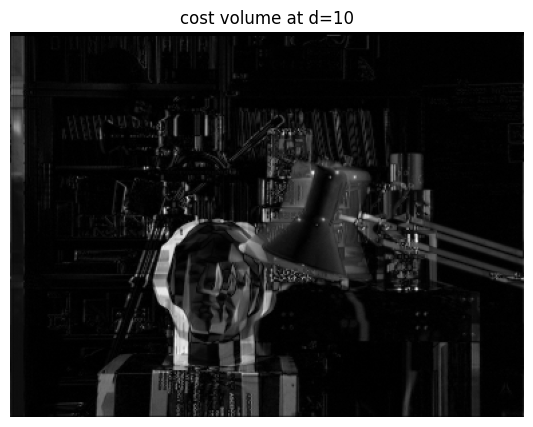

In [37]:
def compute_cost_layer(left_image, right_image, disparity, alpha, Tc, Tg, left):
        cost_layer = np.zeros((left_image.shape[0], left_image.shape[1]))

        #translate right image according to disparity
        num_rows, num_cols = right_image.shape[:2]
        if(left):
             trans = np.float32([[1,0,disparity], [0,1,0]])
        else:
             trans = np.float32([[1,0,-disparity], [0,1,0]])
        
        right_trans = cv.warpAffine(right_image, trans, (num_cols,num_rows))

        #calculate pixelwise absolute color difference between left image and translated right image
        diff_col = cv.absdiff(left_image, right_trans)
        diff_col = np.sum(diff_col, axis=-1)

        #calculate pixelwise gradient(in x direction) difference between left and translated right image
        left_gray = cv.cvtColor(left_image, cv.COLOR_BGR2GRAY)
        right_gray = cv.cvtColor(right_trans, cv.COLOR_BGR2GRAY)
        kernel = np.array([[-1,0,1]])
        grad_left = cv.filter2D(left_gray, -1, kernel)
        grad_right = cv.filter2D(right_gray, -1, kernel)
        diff_grad = cv.absdiff(grad_left, grad_right)

        #calculate cost
        for x in range (cost_layer.shape[0]):
            for y in range (cost_layer.shape[1]):
                cost_layer[x,y] = alpha * min(Tc, diff_col[x,y]) + (1- alpha) * min(Tg, diff_grad[x,y])

        return cost_layer

def compute_cost_volume(left_image, right_image, max_disparity, alpha, Tc, Tg, left):

    #calculate cost layers parallely
    cost_volume = Parallel(n_jobs=6)(delayed (compute_cost_layer)(left_image, right_image, d, alpha, Tc, Tg, left) for d in range(max_disparity+1))

    #have to convert the list created by "Parallel" to np.array and reshape to fit shape (H ,W , max_disparity)
    cost_volume = np.array(cost_volume)
    cost_volume = np.transpose(cost_volume, (1,2,0))

    return cost_volume #(H ,W , max_disparity)

# float64
cost_volume =compute_cost_volume(left_image, right_image,20,1,255*3,255*3,True)

plt.imshow(cost_volume[:,:,10], cmap="gray")
plt.axis("off")
plt.title("cost volume at d=10")
plt.show()

#### Apply average filter and select best disparity values from cost volume

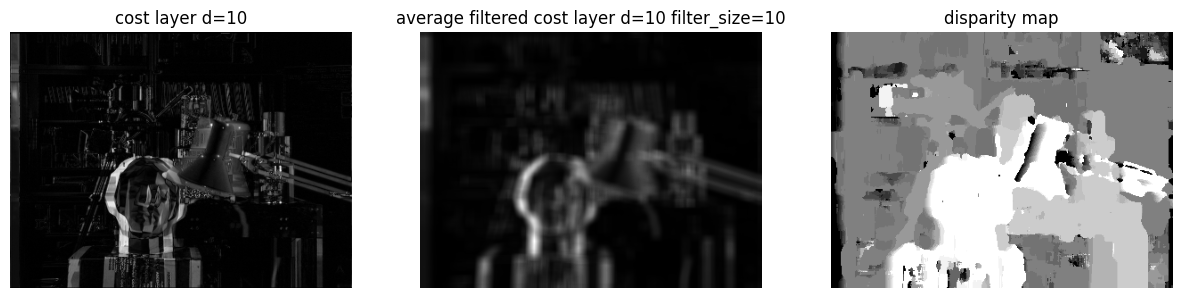

In [38]:
def average_filter(cost_volume, kernel_size):
    # TODO: implement
    filtered_volume = np.zeros(shape=cost_volume.shape)
    for d in range(filtered_volume.shape[2]):
        layer = cost_volume[:,:,d]
        blur = cv.blur(layer,(kernel_size,kernel_size))
        filtered_volume[:,:,d] = blur
    return filtered_volume

def compute_disparity_from_cost_volume(cost_volume):
    # TODO: implement
    disparity_map = np.argmin(cost_volume, axis=2)
    return disparity_map

# float64
cost_volume_filtered_avg = average_filter(cost_volume,10)
# int64
disparity_map_filtered_avg = compute_disparity_from_cost_volume(cost_volume_filtered_avg)

fig = plt.figure(figsize=(15,15))
rows = 1
columns = 3
fig.add_subplot(rows,columns,1)
plt.imshow(cost_volume[:,:,10], cmap="gray")
plt.axis("off")
plt.title("cost layer d=10")
fig.add_subplot(rows,columns,2)
plt.axis("off")
plt.title("average filtered cost layer d=10 filter_size=10")
plt.imshow(cost_volume_filtered_avg[:,:,10], cmap="gray")
fig.add_subplot(rows,columns,3)
plt.axis("off")
plt.title("disparity map")
plt.imshow(disparity_map_filtered_avg, cmap="gray")
plt.show()

#### Compute and visualize your results


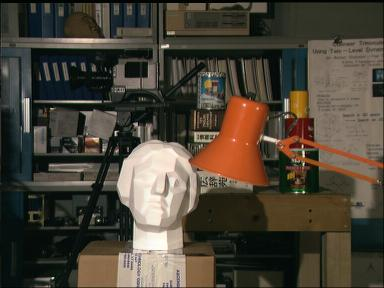
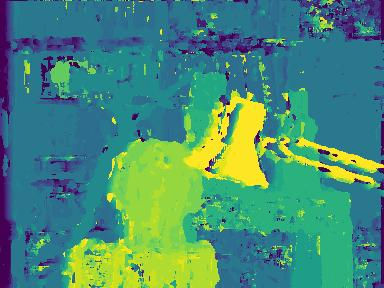

In [39]:
## Parameters
# TODO: Find optimal parameters
average_filter_kernel = 5
max_disparity = 25
alpha = 0.6 #high alpha means high influence of color difference and lower influence of gradient distance)
Tc = 50
Tg = 30

# Compute cost volume
# float64
cost_volume = compute_cost_volume(left_image, right_image, max_disparity=max_disparity, alpha=alpha, Tc=Tc, Tg=Tg, left= True)

# Apply the average filter
# float64
cost_volume = average_filter(cost_volume, average_filter_kernel)

# Compute the disparity from the cost volume
# int64
disparity = compute_disparity_from_cost_volume(cost_volume)
disparity_avg_filter = disparity

# Visualize the results
plot_compare(left_image, disparity, height=400)

## Task 2 - Guided image filtering (25 points)
- Implement and apply the guided image filter instead of the average filter of Task 1. (15 points)
- Select best parameters and visualize your results. (10 points)


#### Apply the guided image filter instead of the average filter of Task 1 and select best parameters

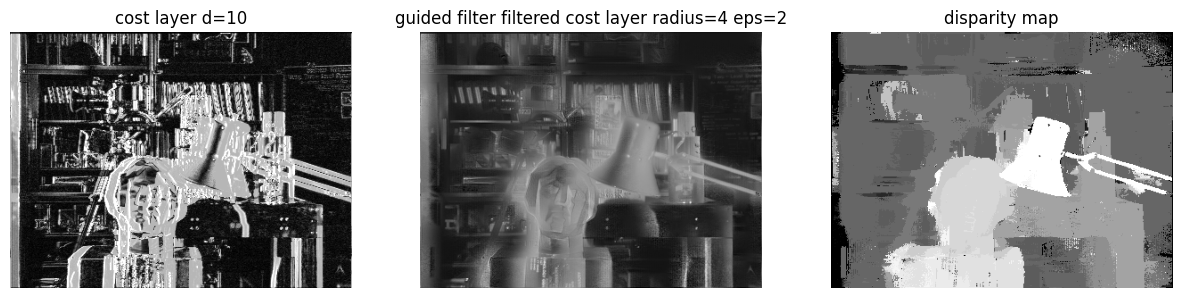

In [40]:
def guided_cost_volume_filter(cost_volume, guidance_image, window_size, eps):
    guided_cost_volume = np.zeros_like(cost_volume)
    # TODO: implement the guided cost volume filter with the class "GuidedFilter" in guided_filter.py
    # optional: use joblib for parallelization    
    #using the pre given GuildedFilter class to filter the cost volume matrix
    guidedFilter = guided_filter.GuidedFilter(guidance_image, window_size, eps)
    guided_cost_volume = guidedFilter.filter(cost_volume)
    return guided_cost_volume

#plotting the results
# Compute cost volume
# float64
cost_volume = compute_cost_volume(left_image, right_image, max_disparity=max_disparity, alpha=alpha, Tc=Tc, Tg=Tg, left= True)
filtered_vol = guided_cost_volume_filter(cost_volume, left_image, 9, 0)

disparity_map = compute_disparity_from_cost_volume(filtered_vol)
disparity_guided_filter = disparity_map

fig = plt.figure(figsize=(15,15))
rows = 1
columns = 3
fig.add_subplot(rows,columns,1)
plt.imshow(cost_volume[:,:,10], cmap="gray")
plt.axis("off")
plt.title("cost layer d=10")
fig.add_subplot(rows,columns,2)
plt.axis("off")
plt.title("guided filter filtered cost layer window_size=9 eps=0")
plt.imshow(filtered_vol[:,:,10], cmap="gray")
fig.add_subplot(rows,columns,3)
plt.axis("off")
plt.title("disparity map")
plt.imshow(disparity_map, cmap="gray")
plt.show()

#### Visualize your results


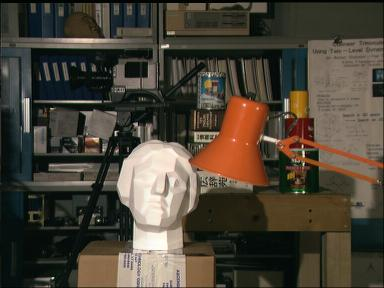
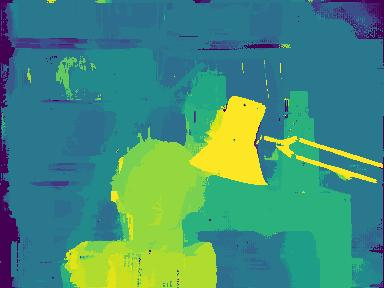

In [41]:
# TODO: set suitable parameters
alpha = 0.9
Tc = 7
Tg = 2
window_size = 9
eps = 0.0001

cost_volume = compute_cost_volume(left_image, right_image, max_disparity=max_disparity, alpha=alpha, Tc=Tc, Tg=Tg, left=True)
guided_cost_volume = guided_cost_volume_filter(cost_volume, left_image, window_size, eps)
guided_disparity = compute_disparity_from_cost_volume(guided_cost_volume)
plot_compare(left_image, guided_disparity, height=400)

## Task 3 - Post processing (25 points)
- Compute disparity maps for the left and right reference image. (5 points)
- Mark inconsistent pixels. (5 points)
- Infill inconsistent pixels with nearby disparity values. (10 points)
- Apply median filter and visualize the result. (5 points)

#### Compute disparity maps for the left and right reference image


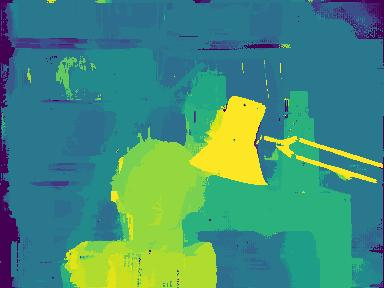
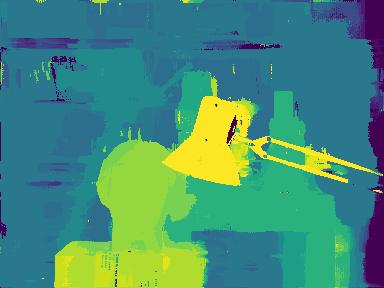

In [42]:
Tc = 7
Tg = 2

def compute_disparity(left_image, right_image):
    cost_volume = compute_cost_volume(left_image, right_image, max_disparity=max_disparity, alpha=0.9, Tc=Tc, Tg=Tg, left=True)
    guided_cost_volume = guided_cost_volume_filter(cost_volume, left_image, window_size, eps)
    guided_disparity = compute_disparity_from_cost_volume(guided_cost_volume)
    return guided_disparity

def compute_disparity_right(left_image, right_image):
    cost_volume = compute_cost_volume(right_image, left_image, max_disparity=max_disparity, alpha=0.9, Tc=Tc, Tg=Tg, left=False)
    guided_cost_volume = guided_cost_volume_filter(cost_volume, right_image, window_size, eps)
    guided_disparity = compute_disparity_from_cost_volume(guided_cost_volume)
    return guided_disparity

# compute left disparity
left_disparity = compute_disparity(left_image, right_image)

# TODO: compute right disparity
right_disparity = compute_disparity_right(left_image, right_image)

plot_compare(left_disparity, right_disparity, height=400)

#### Mark inconsistent pixels

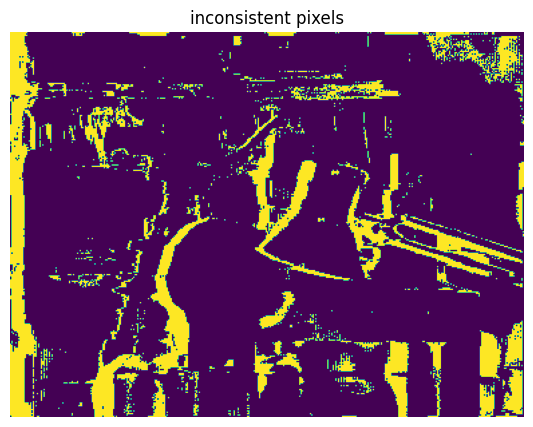

In [43]:
inconsistent_pixels = np.zeros_like(left_disparity, dtype=bool)
for x in range(len(left_disparity)):
    for y in range(len(left_disparity[0])):
        current_disp_left = left_disparity[x][y]
        current_disp_right = right_disparity[x][y-current_disp_left]
             
        if(current_disp_left == current_disp_right or current_disp_left == current_disp_right + 1 or current_disp_left == current_disp_right -1):
            inconsistent_pixels[x][y] = False
        else:
            inconsistent_pixels[x][y] = True


#inconsistent_pixels[:, :] = False
fig.add_subplot(rows,columns,1)
plt.imshow(inconsistent_pixels)
plt.axis("off")
plt.title("inconsistent pixels")
plt.show()

# TODO: mark inconsistent pixels

#### Infill inconsistent pixels with nearby disparity values


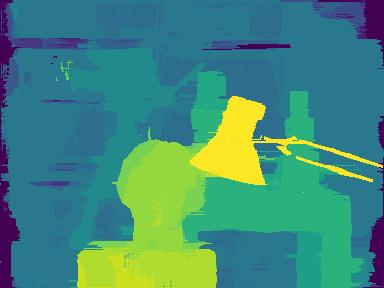
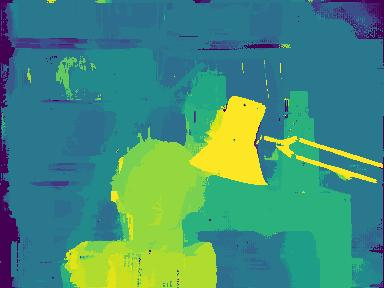

In [65]:
def inpaint_inconsistent_pixels(disparity, inconsistent_pixels):
    new_disparity = np.copy(disparity)
    # TODO: infill inconsistent pixels with nearby disparity values

    for x in range(len(inconsistent_pixels)):
        for y in range(len(inconsistent_pixels[0])):
            if(inconsistent_pixels[x][y] == True):
                for z in range(1, y):
                    if inconsistent_pixels[x][y-z] == False:
                        new_disparity[x][y] = disparity[x][y-z]
                        break
                for z in range(1, len(inconsistent_pixels[0]) - y):#
                    if inconsistent_pixels[x][y+z] == False:
                        new_disparity[x][y] = min(new_disparity[x][y], disparity[x][y+z])
                        break
                            
    return new_disparity
   
disparity_inpainted = inpaint_inconsistent_pixels(left_disparity, inconsistent_pixels)
plot_compare(disparity_inpainted, left_disparity, height=400)


#### Apply median filter


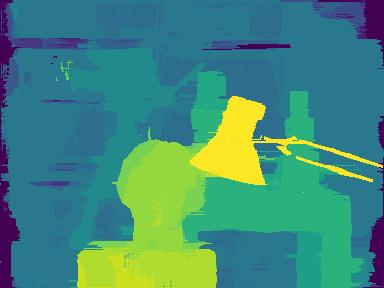
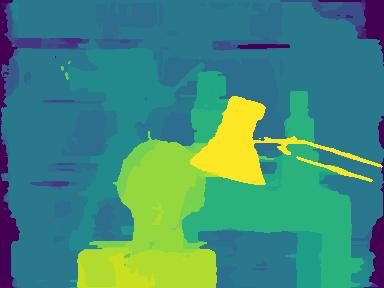

In [66]:
disparity_inpainted_blurred = cv.medianBlur(np.uint16(disparity_inpainted), 3)
plot_compare(disparity_inpainted, disparity_inpainted_blurred, height=400)


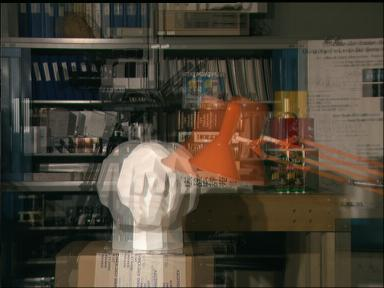
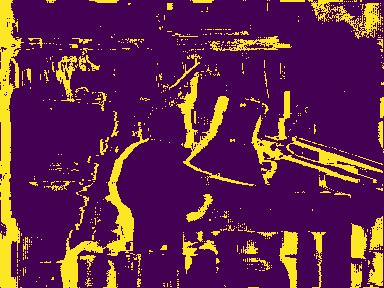

In [46]:

plot_compare(left_image / 255 *0.5+right_image / 255*0.5, inconsistent_pixels, height=400)


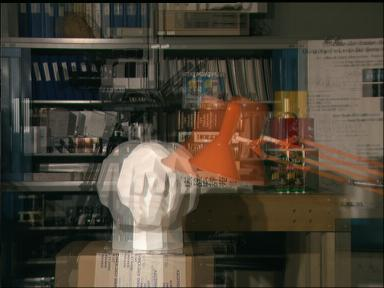
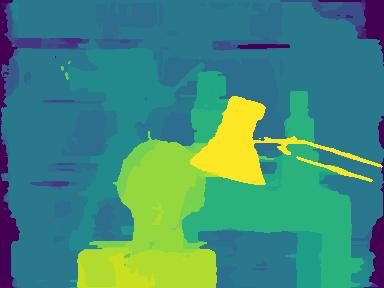

In [47]:
plot_compare(left_image / 255 *0.5+right_image / 255 *0.5, disparity_inpainted, height=400)


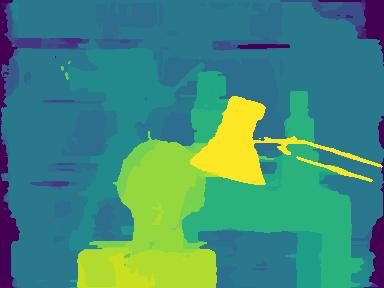
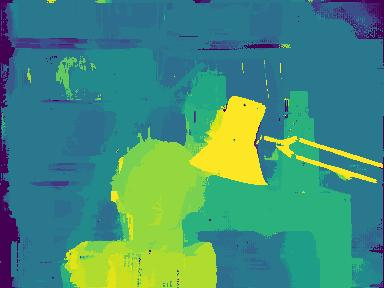

In [48]:
plot_compare(disparity_inpainted, left_disparity, height=400)

## Task 4 - Evaluation (25 points)
- Compute the mean difference and the accuracy of the results. (5 Points)
- Compare the results from the different tasks, by showing them side-by-side additionally to the ground truth and by comparing the metrics applied to the results. (5 Points)
- Repeat those steps with two other images from the middlebury dataset. (10 Points)
- Discuss the results. (5 Points)


#### Compute the mean difference and accuracy of the results


In [56]:
# TODO: load ground truth and compute metrics
gt = read_image(gt_path)
gt = (gt[:,:,0]/8).astype("int64")

disparity_inpainted_blurred = disparity_inpainted_blurred.astype("int64")

# accuracy is the amount of correct classifications in relation to all classifications

#average filtered result
diff_avg_filter = cv.absdiff(gt, disparity_avg_filter)
mean_avg_filter = np.round(np.mean(diff_avg_filter), 3)
correct = np.sum(gt == disparity_avg_filter)
all = disparity_avg_filter.shape[0] * disparity_avg_filter.shape[1]
acc_avg_filter = np.round(correct / all, 3)

#guided filtered result
diff_guided_filter = cv.absdiff(gt, disparity_guided_filter)
mean_guided_filter = np.round(np.mean(diff_guided_filter), 3)
correct = np.sum(gt == disparity_guided_filter)
all = disparity_guided_filter.shape[0] * disparity_guided_filter.shape[1]
acc_guided_filter = np.round(correct / all, 3)

#inpainted_blurred result
diff_inpainted_blurred = cv.absdiff(gt, disparity_inpainted_blurred)
mean_inpainted_blurred = np.round(np.mean(diff_inpainted_blurred), 3)
correct = np.sum(gt == disparity_inpainted_blurred)
all = disparity_inpainted_blurred.shape[0] * disparity_inpainted_blurred.shape[1]
acc_inpainted_blurred = np.round(correct / all, 3)

#### Compare the results from the different tasks

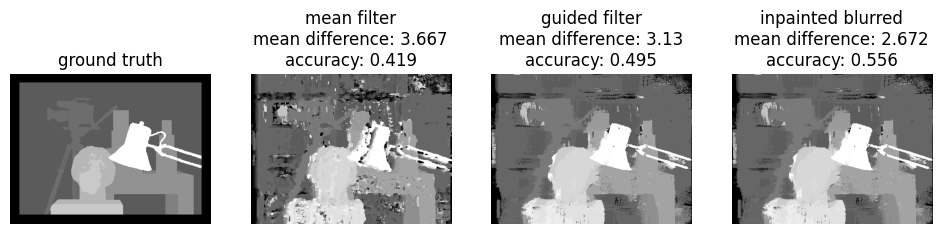

In [57]:
# TODO: display the disparity maps from the different tasks as well as the ground truth
fig = plt.figure(figsize=(15,15))
rows = 1
columns = 5
###
fig.add_subplot(rows,columns,1)
plt.imshow(gt, cmap="gray")
plt.axis("off")
plt.title("ground truth")
###
fig.add_subplot(rows,columns,2)
plt.axis("off")
plt.title("mean filter" + "\n" + "mean difference: " + str(mean_avg_filter) + "\n" + "accuracy: " + str(acc_avg_filter))
plt.imshow(disparity_avg_filter, cmap="gray")
###
fig.add_subplot(rows,columns,3)
plt.axis("off")
plt.title("guided filter" + "\n" + "mean difference: " + str(mean_guided_filter) + "\n" + "accuracy: " + str(acc_guided_filter))
plt.imshow(disparity_map, cmap="gray")
###
fig.add_subplot(rows,columns,4)
plt.axis("off")
plt.title("inpainted blurred" + "\n" + "mean difference: " + str(mean_inpainted_blurred) + "\n" + "accuracy: " + str(acc_inpainted_blurred))
plt.imshow(disparity_map, cmap="gray")
###
plt.show()

# TODO: calculate the evaluation metrics for each of the results 


#### Repeat those steps with two other images from the middlebury dataset

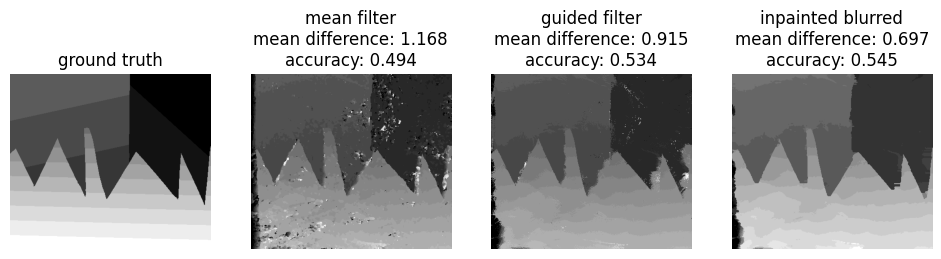

In [80]:
# TODO: implement the evaluation of two additional images

## SAWTOOTH
left_image_path = 'sawtooth/im2.ppm'
right_image_path = 'sawtooth/im6.ppm'
gt_path = 'sawtooth/disp2.pgm'
gt_scale = 0 # HINT: find information about how to scale the ground truth disparity on the middleburry website

left_image = read_image(left_image_path)
right_image = read_image(right_image_path)
gt = read_image(gt_path)

#average filter
average_filter_kernel = 5
max_disparity = 25
alpha = 0.6
Tc = 50
Tg = 30
cost_volume = compute_cost_volume(left_image, right_image, max_disparity=max_disparity, alpha=alpha, Tc=Tc, Tg=Tg, left= True)
cost_volume = average_filter(cost_volume, average_filter_kernel)
disparity_avg_filter = compute_disparity_from_cost_volume(cost_volume)

#guided filter
cost_volume = compute_cost_volume(left_image, right_image, max_disparity=max_disparity, alpha=alpha, Tc=Tc, Tg=Tg, left= True)
filtered_vol = guided_cost_volume_filter(cost_volume, left_image, 9, 0)
disparity_guided_filter = compute_disparity_from_cost_volume(filtered_vol)

#post processing
left_disparity = compute_disparity(left_image, right_image)
right_disparity = compute_disparity_right(left_image, right_image)
inconsistent_pixels = np.zeros_like(left_disparity, dtype=bool)
for x in range(len(left_disparity)):
    for y in range(len(left_disparity[0])):
        current_disp_left = left_disparity[x][y]
        current_disp_right = right_disparity[x][y-current_disp_left]
             
        if(current_disp_left == current_disp_right or current_disp_left == current_disp_right + 1 or current_disp_left == current_disp_right -1):
            inconsistent_pixels[x][y] = False
        else:
            inconsistent_pixels[x][y] = True
disparity_inpainted = inpaint_inconsistent_pixels(left_disparity, inconsistent_pixels)
disparity_inpainted_blurred = cv.medianBlur(np.uint16(disparity_inpainted), 3)

#metrics
gt = (gt[:,:,0]/8).astype("int64")
disparity_inpainted_blurred = disparity_inpainted_blurred.astype("int64")
#average filtered result
diff_avg_filter = cv.absdiff(gt, disparity_avg_filter)
mean_avg_filter = np.round(np.mean(diff_avg_filter), 3)
correct = np.sum(gt == disparity_avg_filter)
all = disparity_avg_filter.shape[0] * disparity_avg_filter.shape[1]
acc_avg_filter = np.round(correct / all, 3)
#guided filtered result
diff_guided_filter = cv.absdiff(gt, disparity_guided_filter)
mean_guided_filter = np.round(np.mean(diff_guided_filter), 3)
correct = np.sum(gt == disparity_guided_filter)
all = disparity_guided_filter.shape[0] * disparity_guided_filter.shape[1]
acc_guided_filter = np.round(correct / all, 3)
#inpainted_blurred result
diff_inpainted_blurred = cv.absdiff(gt, disparity_inpainted_blurred)
mean_inpainted_blurred = np.round(np.mean(diff_inpainted_blurred), 3)
correct = np.sum(gt == disparity_inpainted_blurred)
all = disparity_inpainted_blurred.shape[0] * disparity_inpainted_blurred.shape[1]
acc_inpainted_blurred = np.round(correct / all, 3)

#visualization
fig = plt.figure(figsize=(15,15))
rows = 1
columns = 5
###
fig.add_subplot(rows,columns,1)
plt.imshow(gt, cmap="gray")
plt.axis("off")
plt.title("ground truth")
###
fig.add_subplot(rows,columns,2)
plt.axis("off")
plt.title("mean filter" + "\n" + "mean difference: " + str(mean_avg_filter) + "\n" + "accuracy: " + str(acc_avg_filter))
plt.imshow(disparity_avg_filter, cmap="gray")
###
fig.add_subplot(rows,columns,3)
plt.axis("off")
plt.title("guided filter" + "\n" + "mean difference: " + str(mean_guided_filter) + "\n" + "accuracy: " + str(acc_guided_filter))
plt.imshow(disparity_guided_filter, cmap="gray")
###
fig.add_subplot(rows,columns,4)
plt.axis("off")
plt.title("inpainted blurred" + "\n" + "mean difference: " + str(mean_inpainted_blurred) + "\n" + "accuracy: " + str(acc_inpainted_blurred))
plt.imshow(disparity_inpainted_blurred, cmap="gray")
###
plt.show()





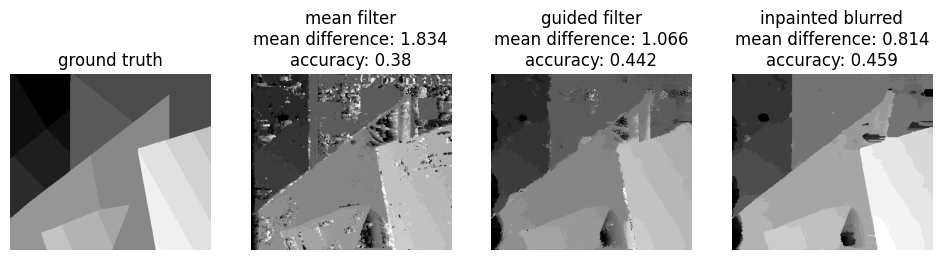

In [81]:
# TODO: implement the evaluation of two additional images

## POSTER
left_image_path = 'poster/im2.ppm' # load tsukuba images
right_image_path = 'poster/im6.ppm'
gt_path = 'poster/disp2.pgm'
gt_scale = 0 # HINT: find information about how to scale the ground truth disparity on the middleburry website

left_image = read_image(left_image_path)
right_image = read_image(right_image_path)
gt = read_image(gt_path)

#average filter
average_filter_kernel = 5
max_disparity = 25
alpha = 0.6
Tc = 50
Tg = 30
cost_volume = compute_cost_volume(left_image, right_image, max_disparity=max_disparity, alpha=alpha, Tc=Tc, Tg=Tg, left= True)
cost_volume = average_filter(cost_volume, average_filter_kernel)
disparity_avg_filter = compute_disparity_from_cost_volume(cost_volume)

#guided filter
cost_volume = compute_cost_volume(left_image, right_image, max_disparity=max_disparity, alpha=alpha, Tc=Tc, Tg=Tg, left= True)
filtered_vol = guided_cost_volume_filter(cost_volume, left_image, 9, 0)
disparity_guided_filter = compute_disparity_from_cost_volume(filtered_vol)

#post processing
left_disparity = compute_disparity(left_image, right_image)
right_disparity = compute_disparity_right(left_image, right_image)
inconsistent_pixels = np.zeros_like(left_disparity, dtype=bool)
for x in range(len(left_disparity)):
    for y in range(len(left_disparity[0])):
        current_disp_left = left_disparity[x][y]
        current_disp_right = right_disparity[x][y-current_disp_left]
             
        if(current_disp_left == current_disp_right or current_disp_left == current_disp_right + 1 or current_disp_left == current_disp_right -1):
            inconsistent_pixels[x][y] = False
        else:
            inconsistent_pixels[x][y] = True
disparity_inpainted = inpaint_inconsistent_pixels(left_disparity, inconsistent_pixels)
disparity_inpainted_blurred = cv.medianBlur(np.uint16(disparity_inpainted), 3)

#metrics
gt = (gt[:,:,0]/8).astype("int64")
disparity_inpainted_blurred = disparity_inpainted_blurred.astype("int64")
#average filtered result
diff_avg_filter = cv.absdiff(gt, disparity_avg_filter)
mean_avg_filter = np.round(np.mean(diff_avg_filter), 3)
correct = np.sum(gt == disparity_avg_filter)
all = disparity_avg_filter.shape[0] * disparity_avg_filter.shape[1]
acc_avg_filter = np.round(correct / all, 3)
#guided filtered result
diff_guided_filter = cv.absdiff(gt, disparity_guided_filter)
mean_guided_filter = np.round(np.mean(diff_guided_filter), 3)
correct = np.sum(gt == disparity_guided_filter)
all = disparity_guided_filter.shape[0] * disparity_guided_filter.shape[1]
acc_guided_filter = np.round(correct / all, 3)
#inpainted_blurred result
diff_inpainted_blurred = cv.absdiff(gt, disparity_inpainted_blurred)
mean_inpainted_blurred = np.round(np.mean(diff_inpainted_blurred), 3)
correct = np.sum(gt == disparity_inpainted_blurred)
all = disparity_inpainted_blurred.shape[0] * disparity_inpainted_blurred.shape[1]
acc_inpainted_blurred = np.round(correct / all, 3)

#visualization
fig = plt.figure(figsize=(15,15))
rows = 1
columns = 5
###
fig.add_subplot(rows,columns,1)
plt.imshow(gt, cmap="gray")
plt.axis("off")
plt.title("ground truth")
###
fig.add_subplot(rows,columns,2)
plt.axis("off")
plt.title("mean filter" + "\n" + "mean difference: " + str(mean_avg_filter) + "\n" + "accuracy: " + str(acc_avg_filter))
plt.imshow(disparity_avg_filter, cmap="gray")
###
fig.add_subplot(rows,columns,3)
plt.axis("off")
plt.title("guided filter" + "\n" + "mean difference: " + str(mean_guided_filter) + "\n" + "accuracy: " + str(acc_guided_filter))
plt.imshow(disparity_guided_filter, cmap="gray")
###
fig.add_subplot(rows,columns,4)
plt.axis("off")
plt.title("inpainted blurred" + "\n" + "mean difference: " + str(mean_inpainted_blurred) + "\n" + "accuracy: " + str(acc_inpainted_blurred))
plt.imshow(disparity_inpainted_blurred, cmap="gray")
###
plt.show()




#### Discuss the results

TODO: Discuss the results here

guided filter filter and post processing each make the result better
assumption that similar color means similar disparity
--> complex patterns result in worse results
infilling should handle occluded parts of the image, however it's not perfect
accuracy ca. 0.5 --> hitting the exact values is hard

Tc=30 Tg=10
1. mean 2.672 acc 0.556
2. mean 0.697 acc 0.545
3. mean 0.814 acc 0.459